In [1]:
# import packages for uploading data
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('grayscale')

from scipy.stats import ttest_ind as tt
from scipy.stats import linregress, norm

# import Sklearn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel

# # import stats library
# from statsmodels.discrete.discrete_model import Logit
# import statsmodels.api as sm 

def std_X(X, X_ref):
    X_std = (X - np.mean(X_ref, 0)) / np.std(X_ref, 0)
    return X_std

np.random.seed(123)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cvsmxuk3 because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home/jaron/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
table = pd.read_csv('data/orig_pgm_data_notaxa_BF.csv')

table.head(10)

,sample ID,DOC,TotalBiomass,fungAbundance,bactAbundance,FungRichness,FungDiversity,BactRichness,BactDiversity,BF ratio
0,6,High,1207.800000,1.602098e+07,5.967869e+07,107.0,2.974775,452.0,5.542429,3.725034
1,8,High,337.900000,1.482245e+06,3.249390e+07,82.0,3.079463,423.0,5.476742,21.922088
2,12,High,749.181818,7.541044e+06,7.452687e+07,128.0,3.605976,450.0,5.552623,9.882832
3,18,High,100.545455,8.669971e+05,7.267914e+06,98.0,3.771869,378.0,5.300784,8.382858
4,19,Low,745.100000,4.295431e+06,5.629933e+07,103.0,3.382549,194.0,3.389620,13.106795
5,21,High,495.400000,5.254666e+06,9.271271e+07,82.0,2.936919,393.0,5.344952,17.643882
6,22,High,1144.000000,2.575957e+07,1.422591e+08,NaN,NaN,312.0,4.713595,5.522574
7,25,High,691.000000,4.395736e+06,1.044248e+08,146.0,2.979738,469.0,5.515387,23.755941
8,26,Low,2150.772727,1.845686e+07,1.740139e+08,134.0,3.757386,483.0,5.693188,9.428140
9,28,High,695.700000,2.129917e+07,2.343236e+08,166.0,3.630497,466.0,5.608685,11.001536


In [3]:
# set up X to be the matrix of features 
X = np.array(table.values[:, 2:-1], np.double)
feature_names = table.columns.values[2:-1]
sample_names = table.iloc[:, 0].values

# remove samples with NAN 
indsnan = np.array([not i for i in np.isnan(np.sum(X, 1))])
X = X[indsnan, :]

# set of DOC binary vector 
DOC = table['DOC'].values[indsnan]
DOC_ctg = np.zeros(len(DOC))

for i, doc in enumerate(DOC):
    if doc == 'High':
        DOC_ctg[i] = 1
    else:
        DOC_ctg[i] = 0

n_train = int(.7*X.shape[0]) 

print(feature_names)

['TotalBiomass' 'fungAbundance' 'bactAbundance' 'FungRichness'
 'FungDiversity' 'BactRichness' 'BactDiversity']


In [4]:
def get_perm_ID(rand_inds):
    ID = ""
    for i in sorted(rand_inds):
        ID += str(i)
    return ID

def get_train_test(X, DOC_ctg, n_train):
    
    n, m = X.shape
    
    # convert X to a dataframe to keep track of index 
    X = pd.DataFrame(X)
    
    X_high = X.iloc[DOC_ctg==1, :]
    X_low  = X.iloc[DOC_ctg==0, :]
    
    # shuffle X_high and keep track of DOC labels 
    randargs_high = np.random.permutation(X_high.shape[0])
    randargs_low  = np.random.permutation(X_low.shape[0])
    
    X_high = X_high.iloc[randargs_high, :]
    X_low  = X_low.iloc[randargs_low, :]
    
    DOC_high = DOC_ctg[DOC_ctg==1][randargs_high]
    DOC_low  = DOC_ctg[DOC_ctg==0][randargs_low]
    
    # set aside n_train/n for training
    n_train_high = int(X_high.shape[0] * n_train / n)
    n_train_low = int(X_low.shape[0] * n_train / n)
    
    X_train = pd.concat((X_high.iloc[:n_train_high, :], X_low.iloc[:n_train_low, :]), axis=0) 
    X_test  = pd.concat((X_high.iloc[n_train_high:, :], X_low.iloc[n_train_low:, :]), axis=0) 
    
    DOC_train = np.append(DOC_high[:n_train_high], DOC_low[:n_train_low])
    DOC_test  = np.append(DOC_high[n_train_high:], DOC_low[n_train_low:]) 
    
    # shuffle the training and testing data 
    randargs_train = np.random.permutation(X_train.shape[0])
    X_train = X_train.iloc[randargs_train, :]
    DOC_train = DOC_train[randargs_train]
    
    randargs_test = np.random.permutation(X_test.shape[0])
    X_test = X_test.iloc[randargs_test, :]
    DOC_test = DOC_test[randargs_test]
    
    X_train_std = std_X(X_train.values, X_train.values)
    X_test_std  = std_X(X_test.values, X_train.values)
    
    test_inds = X_test.index.values
    
    return X_train_std, X_test_std, DOC_train, DOC_test, get_perm_ID(test_inds)

In [5]:
def calc_accuracy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tn + tp) / len(y_true)
    return accuracy

In [6]:
# set up X to be the matrix of features 

# run permutations using logistic regression (LR) model 
N_permutations = 1000
LR_acc_array = np.zeros(N_permutations)
baseline_acc_array = np.zeros(N_permutations)
random_acc_array = np.zeros(N_permutations)
n_test_samples = np.zeros(N_permutations)

# feature names 
LR_importance = np.zeros(len(feature_names))
LR_coefficients = np.zeros(len(feature_names))

# store ID for permutations to avoid duplicate train / test perm
permutation_IDs = []

for i in range(N_permutations):
    
    acceptable = False
    while not acceptable:
        X_train, X_test, DOC_train, DOC_test, permutation_ID = get_train_test(X, DOC_ctg, n_train)
        acceptable = permutation_ID not in permutation_IDs
    permutation_IDs.append(permutation_ID)
    n_test_samples[i] = X_test.shape[0]
    
    # baseline accuracy is if classifier always guesses most common label in test set 
    if sum(DOC_test)/len(DOC_test) < .5: # if there are more 'Low' DOC samples
        baseline_acc = calc_accuracy(DOC_test, np.zeros(len(DOC_test)))
    else:
        baseline_acc = calc_accuracy(DOC_test, np.ones(len(DOC_test)))   
    
    baseline_acc = max([sum(DOC_test)/len(DOC_test), 1-sum(DOC_test)/len(DOC_test)])
    baseline_acc_array[i] = baseline_acc
    
    LR_model_val = LogisticRegression(penalty='l2') 
    LR_model_val.fit(X_train, DOC_train)
    
    SFM = SelectFromModel(LR_model_val, prefit=True)
    
    I_opt = SFM.get_support()
    
    X_train = X_train[:, I_opt]
    X_test = X_test[:, I_opt]
    
    LR_model = LogisticRegression()
    LR_model.fit(X=X_train, y=DOC_train)
    
    DOC_pred = np.array(LR_model.predict(X_test))

    # random chance 
    random_acc = sum(DOC_test == np.random.randint(0, 2, len(DOC_test))) / len(DOC_test)
    random_acc_array[i] = random_acc 
    
    # calculate the accuracy of test predictions
    LR_acc_array[i] = calc_accuracy(DOC_test, DOC_pred)
    
    # determine variable importance using Wald statistic 
    predProbs = LR_model.predict_proba(X_train)

    # Design matrix -- add column of 1's at the beginning of your X_train matrix
    X_design = np.hstack([np.ones((X_train.shape[0], 1)), X_train])

    # Initiate matrix of 0's, fill diagonal with each predicted observation's variance
    V = np.diagflat(np.product(predProbs, axis=1))

    # Covariance matrix
    covLogit = np.linalg.inv(X_design.T @ V @ X_design)

    # Wald statistic (coefficient / s.e.) 
    logitParams = np.insert(LR_model.coef_, 0, LR_model.intercept_)
    waldStat = np.zeros(len(feature_names))
    waldStat[I_opt] = logitParams[1:] / np.sqrt(np.diag(covLogit))[1:]
    ''' 
    # logistic regression using statsmodels 
    
    X_L = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)

    L = Logit(DOC_train, X_L)
    results = L.fit(disp=False)

    coef = results.params
    std_err = np.diagonal(results.cov_params())**.5
    waldStat = (coef / std_err)**2
    
    # calculate the accuracy of test predictions
    DOC_pred = np.round(results.predict(X_test_sm), 0)
    LR_acc_array[i] = calc_accuracy(DOC_test, DOC_pred)
    '''
    LR_importance += waldStat*(1/N_permutations)
    LR_coefficients[I_opt] += logitParams[1:]*(1/N_permutations)
    
    
print("Mean LR accuracy: {:.3f}".format(np.mean(LR_acc_array)))
#print(np.std(LR_acc_array))

z_scores = LR_importance
p_values = 2*(1 - norm.cdf(np.abs(z_scores)))

Mean LR accuracy: 0.728


In [7]:
fs_df = pd.DataFrame()
fs_df['Factor'] = feature_names
fs_df['Avg Coefficient'] = LR_coefficients
fs_df['Avg Wald stat.'] = LR_importance
fs_df['P values'] = p_values
fs_df.head(10)

,Factor,Avg Coefficient,Avg Wald stat.,P values
0,TotalBiomass,-0.998800,-2.445887,0.014450
1,fungAbundance,-0.008040,-0.013611,0.989140
2,bactAbundance,-0.000224,0.000177,0.999859
3,FungRichness,-0.575903,-1.612108,0.106938
4,FungDiversity,0.004173,0.008591,0.993145
5,BactRichness,-0.801204,-0.931539,0.351575
6,BactDiversity,0.710642,0.754432,0.450590


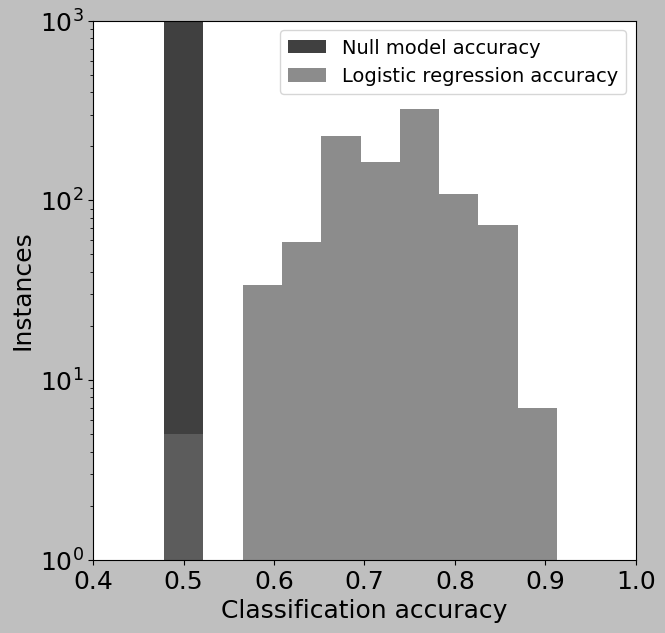

In [8]:
matplotlib.rcParams.update({'font.size':18})
plt.figure(figsize=(7, 7))

bins = np.linspace(0, 1, 24)

plt.hist(baseline_acc_array, color='C0', alpha=.75, label='Null model accuracy', bins=bins)

#plt.hist(random_acc_array, color='C2', alpha=.7, label='Random chance accuracy', bins=bins)

plt.hist(LR_acc_array, alpha=.75, color='C1', label='Logistic regression accuracy', bins=bins)

plt.xlabel('Classification accuracy')
plt.ylabel('Instances')
#plt.title('DOC prediction using day 0 community features')
plt.xlim([.4, 1])
plt.ylim([1, 1000])
plt.yscale('log')
plt.legend(loc='upper right', prop={"size":14})
plt.show()

In [9]:
def Z_proportions(p1, p2, n1, n2):
    P = (p1*n1 + p2*n2) / (n1 + n2)
    Z = (p1 - p2) / np.sqrt(P*(1-P) * (1/n1 + 1/n2))
    return Z

Z_scores = [Z_proportions(p1, p2, n_test, n_test) for p1, p2, n_test in zip(LR_acc_array, baseline_acc_array, n_test_samples)]

median_p_value = norm.sf(np.median(Z_scores))
print("Median p value: {:5f}".format(median_p_value))

Median p value: 0.023913


In [10]:
df = pd.DataFrame()

df['Null model accuracy'] = baseline_acc_array
df['Random chance accuracy'] = random_acc_array
df['LR accuracy'] = LR_acc_array

df['mean LR accuracy'] = [np.mean(LR_acc_array)] + ['']*(len(df)-1)
df['std dev LR accuracy'] = [np.std(LR_acc_array)] + ['']*(len(df)-1)


t, p_LR = tt(LR_acc_array, random_acc_array)
df['p val (LR vs Random)'] = [p_LR] + ['']*(len(df)-1) 

t, p_LR = tt(LR_acc_array, baseline_acc_array)
df['p val (LR vs Null)'] = [p_LR] + ['']*(len(df)-1) 
df.head(10)

,Null model accuracy,Random chance accuracy,LR accuracy,mean LR accuracy,std dev LR accuracy,p val (LR vs Random),p val (LR vs Null)
0,0.514286,0.542857,0.600000,0.727543,0.064528,0.0,0.0
1,0.514286,0.542857,0.742857,,,,
2,0.514286,0.514286,0.714286,,,,
3,0.514286,0.371429,0.657143,,,,
4,0.514286,0.542857,0.742857,,,,
5,0.514286,0.685714,0.828571,,,,
6,0.514286,0.600000,0.771429,,,,
7,0.514286,0.485714,0.742857,,,,
8,0.514286,0.485714,0.771429,,,,
9,0.514286,0.514286,0.800000,,,,
